In [3]:
from pathlib import Path
import pandas as pd
import os
import numpy as np
from dotenv import find_dotenv, load_dotenv

### dirs and dataset

In [4]:
project_dir = os.path.abspath(os.curdir)
project_dir = project_dir.split('recatizer/')[0] + 'recatizer/'
 

In [5]:
raw_data_dir = project_dir + 'data/raw/' # <- The original, immutable data dump.
intermediate_data_output_dir = project_dir + \
        'data/interim/cat_individuals_dataset/'# <- Intermediate data that has been transformed.
processed_data_output_dir = project_dir + \
        'data/processed/'#  <- The final, canonical data sets for modeling.   

In [6]:
dataset = pd.read_csv(raw_data_dir + 'images_database.csv', index_col=0)
dataset.head()

,cat_id,img,path
0,0035,0035_013.JPG,0035/0035_013.JPG
1,0035,0035_009.JPG,0035/0035_009.JPG
2,0035,0035_000.JPG,0035/0035_000.JPG
3,0035,0035_005.JPG,0035/0035_005.JPG
4,0035,0035_003.JPG,0035/0035_003.JPG


#### id 0455_357 and id  0455 the same cat. Fix it manualy

In [7]:
new_id = '0455'

_dataset = dataset.copy()
_dataset.loc[_dataset.cat_id == '0455_357', 'path'] = new_id + '/' + _dataset.path
_dataset.loc[_dataset.cat_id == '0455_357', 'cat_id'] = new_id

print('cat with new_id has more images: ',
    len(_dataset.loc[_dataset.cat_id == new_id,:]) > \
      len(dataset.loc[dataset.cat_id == new_id,:]))

dataset = _dataset

cat with new_id has more images:  True


#### amount files about every cats



In [8]:
def calc_every_cat_files_num(dataset):
    cat_ids = dataset.cat_id.unique()
    # every_cat_imgs_num = 
    every_cat_imgs_num =[]
    for cat_id in cat_ids:
        every_cat_imgs_num.append(
            {'id': cat_id, 
             'amount_files': len(dataset.cat_id[dataset.cat_id == cat_id])}   
        )
    return pd.DataFrame(every_cat_imgs_num)


every_cat_imgs_num = calc_every_cat_files_num(dataset)

In [9]:
every_cat_imgs_num.sort_values(by=['amount_files'], ascending=False).head(20)

,id,amount_files
270,0455,714
89,0454,229
3,0190,144
361,0160,130
440,0375,110
42,0191,101
489,0474,98
5,0212,98
304,0446,95
239,0046,95


array([[<AxesSubplot:title={'center':'amount_files'}>]], dtype=object)

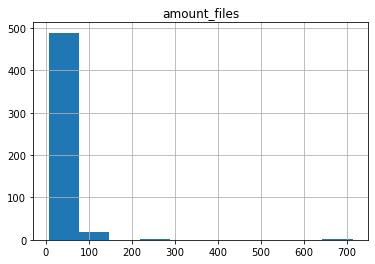

In [10]:
every_cat_imgs_num.hist(column='amount_files')

In [11]:
## file formats

file_formats = set()
for file in dataset.img:
    cur_format = file.split('.')[-1].lower()
    file_formats.add(cur_format)
print('file formats:', file_formats)

file formats: {'mov', 'jpg', 'png', 'heic', 'mp4', 'txt', 'db', 'jpeg'}


### divide into three datasets (imgs, videos, others)

In [12]:
## add column with format label
format_label = []

for row_id in dataset.index:
    dataset.loc[row_id, 'format'] = dataset.loc[row_id, 'img'].split('.')[-1].lower()

In [13]:
def return_files_in_format(df, formats):
    return df.loc[lambda df: df.format.isin(formats)]


video_formats = set(['mp4', 'mov'])
image_formats = set(['jpg', 'heic', 'jpeg', 'png'])
other_formats = file_formats - video_formats - image_formats

images_database = return_files_in_format(dataset, image_formats)
movies_database = return_files_in_format(dataset, video_formats)   
other_database = return_files_in_format(dataset, other_formats)       

In [14]:
def save_df_to_path(df, path, name):
    """save dataset in path"""
    try:
        os.mkdir(path)
    except FileExistsError:
        pass
    
    df.to_csv(path + name)
    return 'ok'

#### Others dataset

In [15]:
calc_every_cat_files_num(other_database)

,id,amount_files
0,0077,1
1,0432,1
2,0131,1
3,0128,1
4,0083,1


In [16]:
save_df_to_path(other_database, intermediate_data_output_dir, 'other_database.csv')

'ok'

#### Movies dataset

In [17]:
calc_every_cat_files_num(movies_database)

,id,amount_files
0,0454,28
1,0200,1
2,0455,20


In [18]:
save_df_to_path(movies_database, intermediate_data_output_dir, 'movies_database.csv')
        

'ok'

#### Images dataset

In [19]:
imgs_num = calc_every_cat_files_num(
    images_database).sort_values(by=['amount_files'], ascending=False)

In [20]:
imgs_num.amount_files.describe()

count    509.000000
mean      27.161100
std       35.977377
min        6.000000
25%       14.000000
50%       20.000000
75%       30.000000
max      694.000000
Name: amount_files, dtype: float64

In [21]:
imgs_num.amount_files.median()

20.0

In [22]:
imgs_num

,id,amount_files
270,0455,694
89,0454,201
3,0190,144
361,0160,130
440,0375,110
...,...,...
377,0039,6
129,0111,6
441,0038,6
321,0130,6


In [23]:
max_img_amount = int(imgs_num.amount_files.median())

extra_cats_imgs = pd.DataFrame()
processed_cats_imgs = pd.DataFrame()

for cat_id in imgs_num.id:
   
    extra_imgs = pd.DataFrame()
    cat_imgs = images_database.loc[dataset.cat_id == cat_id, :]
    if  imgs_num.loc[imgs_num.id==cat_id, 'amount_files'].values > max_img_amount:
            _cat_imgs = cat_imgs.sample(n=max_img_amount, random_state=1) 
            extra_imgs = cat_imgs.drop(_cat_imgs.index)
       
            cat_imgs = _cat_imgs
            extra_cats_imgs = extra_cats_imgs.append(extra_imgs, ignore_index=True)
            
            
    processed_cats_imgs = processed_cats_imgs.append(cat_imgs, ignore_index=True)
        
        

        
    
    
        

array([[<AxesSubplot:title={'center':'amount_files'}>]], dtype=object)

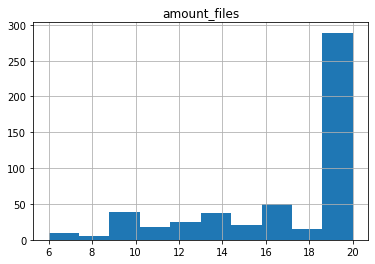

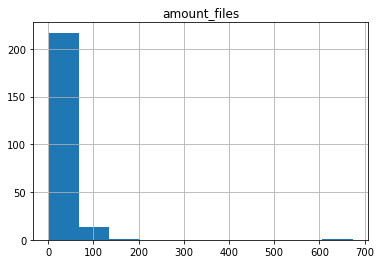

In [24]:
calc_every_cat_files_num(processed_cats_imgs).hist()
calc_every_cat_files_num(extra_cats_imgs).hist()

In [25]:
save_df_to_path(processed_cats_imgs, 
                processed_data_output_dir, 
                'cat_individual_database.csv')
save_df_to_path(extra_cats_imgs, 
                processed_data_output_dir, 
                'cat_individual_database_extra_images.csv')

'ok'

In [26]:
processed_cats_imgs

,cat_id,img,path,format
0,0455,IMG_6935.jpg,0455/0455_357/IMG_6935.jpg,jpg
1,0455,0455_111.heic,0455/0455_111.heic,heic
2,0455,IMG_7724.heic,0455/0455_357/IMG_7724.heic,heic
3,0455,IMG_9541.heic,0455/0455_357/IMG_9541.heic,heic
4,0455,0455_164.heic,0455/0455_164.heic,heic
...,...,...,...,...
8660,0335,0335_003.jpg,0335/0335_003.jpg,jpg
8661,0335,0335_005.jpg,0335/0335_005.jpg,jpg
8662,0335,0335_004.jpg,0335/0335_004.jpg,jpg
8663,0335,0335_002.jpg,0335/0335_002.jpg,jpg


In [27]:
processed_cats_imgs[processed_cats_imgs.cat_id == '0455']

,cat_id,img,path,format
0,0455,IMG_6935.jpg,0455/0455_357/IMG_6935.jpg,jpg
1,0455,0455_111.heic,0455/0455_111.heic,heic
2,0455,IMG_7724.heic,0455/0455_357/IMG_7724.heic,heic
3,0455,IMG_9541.heic,0455/0455_357/IMG_9541.heic,heic
4,0455,0455_164.heic,0455/0455_164.heic,heic
5,0455,0455_238.heic,0455/0455_238.heic,heic
6,0455,IMG_2922.jpg,0455/0455_357/IMG_2922.jpg,jpg
7,0455,0455_286.heic,0455/0455_286.heic,heic
8,0455,0455_258.heic,0455/0455_258.heic,heic
9,0455,IMG_1258.jpg,0455/0455_357/IMG_1258.jpg,jpg


#### path validation

In [28]:
# dataset_dir = 'WRITE YOUR PATH/archive/cat_individuals_dataset/'

# for image_path in processed_cats_imgs.path:
#     status = os.path.exists(dataset_dir + image_path)
#     if not status:
#         print('incorrect: ', image_path)

### test, validate and train samples

In [41]:
cat_id = processed_cats_imgs.cat_id.unique()
cats_amount = len(cat_id)

In [47]:
samples_amount = {}
samples_amount['train']= round(cats_amount * 0.6)
samples_amount['test'] =  round((cats_amount - train_cats_amount) * 2/3)
samples_amount['val'] = cats_amount - samples_amount['train'] - samples_amount['test'] 

print('train cats', samples_amount['train'])
print('test cats', samples_amount['test'])
print('val cats', samples_amount['val'] )

train cats 305
test cats 136
val cats 68


In [51]:
_cat_id

0      0455
1      0454
2      0190
3      0160
4      0375
       ... 
504    0039
505    0111
506    0038
507    0130
508    0335
Length: 509, dtype: object

In [66]:
_cat_id = pd.Series(cat_id.copy())
samples = {}

for sample_name in samples_amount:
    print(len(_cat_id))
    sample_id = _cat_id.sample(n=samples_amount[sample_name], random_state=1)
    _cat_id = _cat_id.drop(sample_id.index)
    sample = pd.DataFrame()
    for cat in _cat_id:
        sample = sample.append(processed_cats_imgs[processed_cats_imgs.cat_id == cat], 
                      ignore_index=True)
    samples[sample_name] = sample
 

509
204
68


In [68]:
for sample_name in samples:
    save_df_to_path(samples[sample_name], 
                processed_data_output_dir, 
                f'{sample_name}.csv')

In [67]:
samples

{'train':      cat_id            img                path format
 0      0454  0454_149.heic  0454/0454_149.heic   heic
 1      0454  0454_040.heic  0454/0454_040.heic   heic
 2      0454  0454_038.heic  0454/0454_038.heic   heic
 3      0454  0454_051.heic  0454/0454_051.heic   heic
 4      0454  0454_041.heic  0454/0454_041.heic   heic
 ...     ...            ...                 ...    ...
 3529   0219   0219_004.JPG   0219/0219_004.JPG    jpg
 3530   0219   0219_002.JPG   0219/0219_002.JPG    jpg
 3531   0219   0219_000.JPG   0219/0219_000.JPG    jpg
 3532   0219   0219_005.JPG   0219/0219_005.JPG    jpg
 3533   0219   0219_006.JPG   0219/0219_006.JPG    jpg
 
 [3534 rows x 4 columns],
 'test':      cat_id           img               path format
 0      0190  0190_036.JPG  0190/0190_036.JPG    jpg
 1      0190  0190_131.JPG  0190/0190_131.JPG    jpg
 2      0190  0190_065.JPG  0190/0190_065.JPG    jpg
 3      0190  0190_113.JPG  0190/0190_113.JPG    jpg
 4      0190  0190_097.JPG  01

In [61]:

#     save_df_to_path(extra_cats_imgs, 
#                 processed_data_output_dir, 
#                 'cat_individual_database_extra_images.csv')

ValueError: ('Lengths must match to compare', (8665,), (305,))

In [62]:
sample_id.values

array(['0470', '0242', '0504', '0079', '0390', '0435', '0397', '0386',
       '0430', '0077', '0329', '0439', '0199', '0047', '0503', '0263',
       '0168', '0436', '0158', '0151', '0371', '0387', '0106', '0247',
       '0512', '0369', '0188', '0037', '0461', '0013', '0278', '0088',
       '0348', '0121', '0468', '0080', '0179', '0375', '0357', '0034',
       '0135', '0012', '0281', '0126', '0299', '0205', '0462', '0353',
       '0505', '0253', '0319', '0230', '0191', '0500', '0295', '0447',
       '0310', '0337', '0159', '0410', '0359', '0266', '0313', '0045',
       '0145', '0246', '0433', '0300', '0225', '0465', '0469', '0228',
       '0306', '0017', '0016', '0283', '0131', '0177', '0404', '0466',
       '0069', '0289', '0506', '0140', '0054', '0202', '0284', '0297',
       '0125', '0272', '0201', '0085', '0377', '0474', '0237', '0502',
       '0039', '0214', '0415', '0514', '0231', '0363', '0448', '0019',
       '0362', '0006', '0248', '0097', '0442', '0438', '0026', '0207',
      

### heik/png to jpg

In [ ]:
from wand.image import Image

def to_jpg(path):
    

In [29]:
pip install whatimage

Note: you may need to restart the kernel to use updated packages.


In [30]:

pip install Wand

Note: you may need to restart the kernel to use updated packages.


In [31]:
import io

import whatimage
import pyheif
from PIL import Image


def decodeImage(bytesIo):

    fmt = whatimage.identify_image(bytesIo)
    print(fmt)
    if fmt in ['heic', 'avif']:
         i = pyheif.read_heif(bytesIo)

         # Extract metadata etc
         for metadata in i.metadata or []:
            if metadata['type']=='Exif':
                 # do whatever
                    print(2)
                    pass

         # Convert to other file format like jpeg
            s = io.BytesIO()
            pi = Image.frombytes(
            mode=i.mode, size=i.size, data=i.data)

            pi.save(s, format="jpeg")
            print(1)
            return pi
            
            


In [ ]:
def to_jpg(path):
    

In [ ]:
i = pyheif.read_heif(img_path)
s = io.BytesIO()
pi = Image.frombytes(
mode=i.mode, size=i.size, data=i.data)

pi.save(s, format="jpeg")

In [ ]:
pi

In [ ]:
with Image.open(img_path) as im:
    im.show()
    

In [ ]:
from wand.image import Image

SourceFile = img_path
TargetFolder=project_dir + 'data/processed/jpg_cats_dataset/'
img=Image(filename=SourceFile)
img.format='jpg'
img.save(filename=TargetFile)
img.close()

In [ ]:
from wand.image import Image


SourceFolder="K:/HeicFolder"
TargetFolder=project_dir + 'data/processed/jpg_cats_dataset/'

for file in os.listdir(SourceFolder):
        SourceFile=SourceFolder + "/" + file
        TargetFile=TargetFolder + "/" + file.replace(".HEIC",".JPG")
        img=Image(filename=SourceFile)
        img.format='jpg'
        img.save(filename=TargetFile)
        img.close()

In [ ]:
processed_cats_imgs = img_path


In [ ]:
from dotenv import find_dotenv, load_dotenv

load_dotenv()
input_filepath = os.environ['CAT_INDIVIDUALS_DS_PATH']
TargetFolder=project_dir + 'data/processed/jpg_cats_dataset/'

In [ ]:
input_filepath